In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams['lines.linewidth'] = 0.2


import experiments

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from datetime import datetime
from itertools import product

In [2]:
class ARDUINO:
    PORT = 'COM3'
    TIMEOUT = 3

class TRACE:
    DEVICE = 'DPO4032'
    COUNT = 10
    TRIGGER_THRESHOLD = 0.3

class ENV:
    PLAIN = [bytes([0,47,19,248,187,17,206,228,199,250,169,221,101,114,163,231])]
    KEY = [bytes([x]*16) for x in range(256)] * TRACE.COUNT

class PATH:
    ROOT = r'.\data'

    @classmethod
    def get_filename(cls):
        return rf'{cls.ROOT}\{TRACE.DEVICE}_{TRACE.COUNT}_{datetime.now().strftime("%y%m%d-%H%m%S")}.pkl'



scope = experiments.ScopeManager()
arduino = experiments.ArduinoProtocol(port=ARDUINO.PORT, timeout=ARDUINO.TIMEOUT)

arduino.close()

In [ ]:
plain_text = []
keys = []
cipher_text = []
trace = []

arduino.connect()

progress_bar = tqdm(list(product(ENV.PLAIN, ENV.KEY)))

for plain, key in progress_bar:

    progress_bar.set_description('Init')
    arduino.initialize(plain, key)
    progress_bar.set_description('Encrypt')
    arduino.encrypt()

    progress_bar.set_description('Power Acquire')
    (main_volt, main_time), (trigger_volt, trigger_time) = scope.get_data(['CH1', 'CH2'])

    progress_bar.set_description('Wait')
    arduino.wait_encrypt_end()

    progress_bar.set_description('Finalize')
    result = arduino.finalize()

    cipher_text.append(np.frombuffer(result, dtype=np.uint8))
    plain_text.append(np.frombuffer(plain, dtype=np.uint8))
    keys.append(np.frombuffer(key, dtype=np.uint8))
    trace.append(main_volt[trigger_volt > TRACE.TRIGGER_THRESHOLD])

arduino.close()

df = pd.DataFrame({
    'plain': plain_text,
    'key': keys,
    'cipher': cipher_text,
    'trace': trace
})

df.to_pickle(PATH.get_filename())

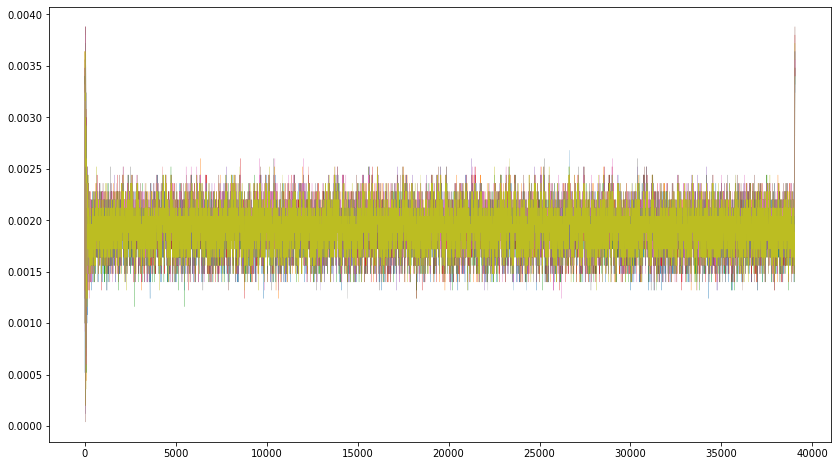

In [26]:
for tr in trace:
    plt.plot(tr)

plt.show()

In [27]:
from tqdm.notebook import tqdm

pbar = tqdm(ENV.PLAIN)

for x in pbar:
    print(x)

[253 103 171 195  52 219  60  63  87 245  74 218  10 123  77 214]
[190  22 121 180 244 179 216 239  44  59 206 223  40 129 108 253]
[172  92  27 247 155  20 167  68 193 154  58 127  54 254   4  66]
[253 103 171 195  52 219  60  63  87 245  74 218  10 123  77 214]
[190  22 121 180 244 179 216 239  44  59 206 223  40 129 108 253]
[172  92  27 247 155  20 167  68 193 154  58 127  54 254   4  66]
[253 103 171 195  52 219  60  63  87 245  74 218  10 123  77 214]
[190  22 121 180 244 179 216 239  44  59 206 223  40 129 108 253]
[172  92  27 247 155  20 167  68 193 154  58 127  54 254   4  66]

